In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import torch.optim as optim
import imblearn
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [102]:
# Load dataset
filename = "./data/wine.csv"
df = pd.read_csv(filename)
df = df.drop('index', axis=1)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [103]:
# Creating a test/train split
train_test_split_fraction = 0.80
split_index = int(df.shape[0] * train_test_split_fraction)
df_train = df[:split_index]
df_test = df[split_index:]

target = pd.get_dummies(df['quality']).values # One hot encode
target[:5]

array([[0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0]], dtype=uint8)

In [104]:
# Selecting the features and the target
X_train = df_train.drop('quality', axis = 1).values
X_test = df_test.drop('quality', axis = 1).values

y_train = target[:split_index]
y_test = target[split_index:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5197, 11)
(1300, 11)
(5197, 7)
(1300, 7)


In [105]:
#change the type
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

In [106]:
#transform into pytorch
X_train = torch.tensor(X_train)   
y_train = torch.tensor(y_train)   
X_test = torch.tensor(X_test)   
y_test = torch.tensor(y_test)

In [107]:
# the neural network architecture of our baseline
nb_hidden_neurons = 200
nb_classes = len(pd.unique(df['quality']))
nb_classes

7

In [108]:
class Network(nn.Module):

    def __init__(self, nb_features):    
        """Here we define the layers
        """

        super().__init__()
        
        self.layer_1 = nn.Linear(nb_features,nb_hidden_neurons)  
        self.layer_2 = nn.Linear(nb_hidden_neurons,nb_hidden_neurons) 
        self.layer_3 = nn.Linear(nb_hidden_neurons,nb_classes) 
        
        

    def forward(self,x):   #forward pass of the neural network learning process
        """Here we combine the layers
        ReLU activation function for the first layers 
        Softmax activation function for the last layer
        """
        
        activation_function = nn.ReLU() 
        last_layer_activation = nn.Softmax(dim=1)
        
        output_first_layer = activation_function(self.layer_1(x)) 
        output_second_layer = activation_function(self.layer_2(output_first_layer)) 
        prediction = last_layer_activation(self.layer_3(output_second_layer))
        return prediction

In [109]:
my_nn = Network(nb_features=X_train.shape[1])
my_nn

Network(
  (layer_1): Linear(in_features=11, out_features=200, bias=True)
  (layer_2): Linear(in_features=200, out_features=200, bias=True)
  (layer_3): Linear(in_features=200, out_features=7, bias=True)
)

In [110]:
import torch.optim
# we define the criterion by which the cost is calculated, 
    #our learning rate and our optimizer, MSELoss, 0.001 and Adam, respectiely.
criterion = nn.MSELoss()    #criterion = loss
learning_rate = 0.001       
optimizer = optim.Adam(my_nn.parameters(), lr=learning_rate ) #Adam optimizer 

In [111]:
#training process
def training(batch_size : int, nb_steps_loss_sum : int):
    """ Train the neural network, feeding it `batch_size` at a time
    and saving statistics every `nb_steps_loss_sum` steps.
    
    Arguments:
    
    - batch_size [int] : the number of input samples at each training step (called a batch)
    - nb_steps_loss_sum [int] : the number of batches before saving the loss for plotting
    
    Returns:
    - loss_list : [List[double]] : value of the loss every `nb_steps_loss_sum` steps
    """

    loss_list = []
    running_loss = 0
    batch_nb = 0

    for epoch in range(0,50): # Number of times to iterate through the complete dataset
        for idx in range(0, X_train.shape[0], batch_size):  
            
            # To Get input and output
            input_batch = X_train[idx:idx + batch_size]
            target = y_train[idx:idx + batch_size]
#             print(target)
            
            optimizer.zero_grad() # - zero gradient buffers
            outputs =  my_nn.forward(input_batch) # - to compute the forward pass
#             print(outputs)
            loss = criterion(outputs,target) # - to compute the loss
            loss.backward() # - backpropagate
            optimizer.step() # - to do a step
          
            
            # Save the loss every `running_loss_steps` batches
            running_loss += loss.item()
            save_loss_condition = batch_nb % nb_steps_loss_sum == (nb_steps_loss_sum - 1)
            if save_loss_condition:    
                loss_list.append(running_loss)
                running_loss = 0.0


            batch_nb+= 1
        
    return loss_list


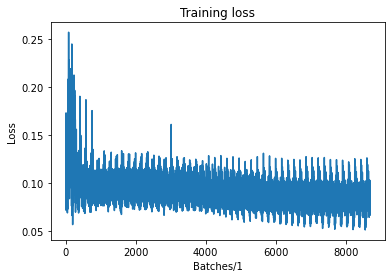

In [112]:
nb_steps_loss_sum = 1
loss = training(batch_size=30, nb_steps_loss_sum=nb_steps_loss_sum)

# Plotting the loss over training
plt.figure()
plt.plot(range(0, len(loss)), loss)
plt.xlabel(f"Batches/{nb_steps_loss_sum}")
plt.ylabel("Loss")
plt.title("Training loss")
plt.show()
plt.close()

In [113]:
def computeScore(X, y):
    correct = 0
    total = y.shape[0]   #we are doing prediction on all items in one shot
    batch_size = 30   # 30 forward pass before a backward
    with torch.no_grad():
        # TO COMPLETE:
    
        # - compute the prediction of the neural network
        output = my_nn.forward(X)  
        # - get the max of the prediction (e.g. get the most likely class) (to do)
        # This can be done using `torch.max`.
        _,predicted = torch.max(output,1)    #predicted = predicted index of the max value and '_' for the max value, we could give another name to the variable (ex: a) instead of '_'...only working with tuple like this output : https://pytorch.org/docs/stable/generated/torch.max.html
        # - get the max of the target (e.g. correct class)
        _,target_pred = torch.max(y,1)

        # - check if the prediction is correct and count it
#             correct += (predicted == target_pred).sum().item() 

#         print(predicted)
#         print(target_pred)

        for idx in range(0, X.shape[0]):
            if predicted[idx] == target_pred[idx]:
                correct += 1

        # - count every sample

    accuracy = correct/total * 100
    print(f"Accuracy of the network on the {total} samples: {accuracy:.2f}%")
    

In [114]:
computeScore(X_train, y_train)
computeScore(X_test, y_test)

Accuracy of the network on the 5197 samples: 51.28%
Accuracy of the network on the 1300 samples: 42.54%


## Resample and preprocessing

In [115]:
# separating target from features
features_2 = df.drop(['sulphates','quality'], axis=1)
target_2 = pd.get_dummies(df['quality']).values # One hot encode

In [116]:
target_2

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [117]:
X = np.array(features_2)
X.shape

(6497, 10)

In [118]:
y = np.array(target_2)
y.shape

(6497, 7)

In [119]:
# splitting to test and train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2) 

In [120]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5197, 10)
(1300, 10)
(5197, 7)
(1300, 7)


In [121]:
#smote = SMOTE(sampling_strategy='minority')
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(X_train, y_train)

/home/abdellah/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2 3 4 5 6] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [122]:
#change the type
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')
#transform into pytorch
X_train = torch.tensor(X_train)   
y_train = torch.tensor(y_train)   
X_test = torch.tensor(X_test)   
y_test = torch.tensor(y_test)

In [123]:
X_train.size()

torch.Size([16002, 10])

In [124]:
y_train.size()

torch.Size([16002, 7])

In [125]:
y_train[0]

tensor([0., 0., 0., 1., 0., 0., 0.])

In [126]:
my_nn = Network(nb_features=X_train.shape[1])
my_nn

Network(
  (layer_1): Linear(in_features=10, out_features=200, bias=True)
  (layer_2): Linear(in_features=200, out_features=200, bias=True)
  (layer_3): Linear(in_features=200, out_features=7, bias=True)
)

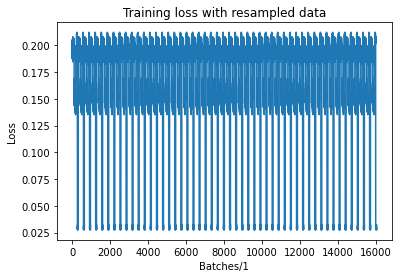

In [127]:
nb_steps_loss_sum = 1
loss = training(batch_size=50, nb_steps_loss_sum=nb_steps_loss_sum)

# Plotting the loss over training
plt.figure()
plt.plot(range(0, len(loss)), loss)
plt.xlabel(f"Batches/{nb_steps_loss_sum}")
plt.ylabel("Loss")
plt.title("Training loss with resampled data")
plt.show()
plt.close()

# Ray Tune hyperparameters optimizer

In [135]:
# Creating a test/train split
train_test_split_fraction = 0.80
split_index = int(df.shape[0] * train_test_split_fraction)
df_train = df[:split_index]
df_test = df[split_index:]

target = pd.get_dummies(df['quality']).values # One hot encode

# Selecting the features and the target
X_train = df_train.drop('quality', axis = 1).values
X_test = df_test.drop('quality', axis = 1).values

y_train = target[:split_index]
y_test = target[split_index:]

#change the type
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

#transform into pytorch
X_train = torch.tensor(X_train)   
y_train = torch.tensor(y_train)   
X_test = torch.tensor(X_test)   
y_test = torch.tensor(y_test)

nb_classes = len(pd.unique(df['quality']))
nb_classes

7

In [141]:
class Network(nn.Module):

    def __init__(self, nb_features, nb_hidden_neurons):    
        """Here we define the layers
        """

        super().__init__()
        
        self.layer_1 = nn.Linear(nb_features,nb_hidden_neurons)  
        self.layer_2 = nn.Linear(nb_hidden_neurons,nb_hidden_neurons) 
        self.layer_last = nn.Linear(nb_hidden_neurons,nb_classes) 
        self.nb_hidden_neurons = nb_hidden_neurons
        
        

    def forward(self,x, nb_hidden_layers, activation_function):   #forward pass of the neural network learning process
        """Here we combine the layers

        """
        
      
        last_layer_activation = nn.Softmax(dim=1)
        
        output_first_layer = activation_function(self.layer_1(x)) 
        output_hidden_layer = activation_function(self.layer_2(output_first_layer))
        for i in range(1, nb_hidden_layers):
            output_hidden_layer = activation_function(self.layer_2(output_hidden_layer))
            
        prediction = last_layer_activation(self.layer_last(output_hidden_layer))
        return prediction

In [142]:
#training process
def training(config, checkpoint_dir=None):
    """ Train the neural network, feeding it `batch_size` at a time
    and saving statistics every `nb_steps_loss_sum` steps.
    
    Arguments:
    
    - batch_size [int] : the number of input samples at each training step (called a batch)
    - nb_steps_loss_sum [int] : the number of batches before saving the loss for plotting
    
    Returns:
    - loss_list : [List[double]] : value of the loss every `nb_steps_loss_sum` steps
    """
    
    nb_steps_loss_sum = 10
    my_nn = Network(nb_features=X_train.shape[1], nb_hidden_neurons=config['hidden_neuron'])
    loss_list = []
    running_loss = 0
    batch_nb = 0
    
    # we define the criterion by which the cost is calculated, 
        #our learning rate and our optimizer(Adam), MSELoss
    
    criterion = nn.MSELoss()              #criterion = loss
    batch_size = config['batch_size']
    learning_rate = config['lr']       
    optimizer = optim.Adam(my_nn.parameters(), lr=learning_rate ) #Adam optimizer 
    

    for epoch in range(0,config['epoch']):       # Number of times to iterate through the complete dataset
        for idx in range(0, X_train.shape[0], batch_size):  
            
            # To Get input and output
            input_batch = X_train[idx:idx + batch_size]
            target = y_train[idx:idx + batch_size]
#             print(target)
            
            optimizer.zero_grad()           # - zero gradient buffers
            
            y_pred =  my_nn(input_batch.float(), nb_hidden_layers = config['nb_layers'], activation_function = config['activation'] )    # - to compute the forward pass
#             print(outputs)
            
            loss = criterion(y_pred,target.float())     # - to compute the loss
            loss.backward()         # - backpropagate
            optimizer.step()        # - to do a step
          
            
            # Save the loss every `running_loss_steps` batches
            running_loss += loss.item()
            save_loss_condition = batch_nb % nb_steps_loss_sum == (nb_steps_loss_sum - 1)
            if save_loss_condition:    
                loss_list.append(running_loss)
                running_loss = 0.0


            batch_nb+= 1
        
    tune.report(mean_loss=abs(loss_list[len(loss_list)-1]))   #to take as the mean loss, the last element of the list_loss
    #acc_train = test(X_train, y_train, config)
    #acc_test = test(X_test, Y_test, config)
    #tune.report(acc_train=acc_train, acc_test=acc_test)

In [143]:
def test(X,y,config, checkpoint_dir=None):
    my_nn = Network(nb_features=X_train.shape[1], nb_hidden_neurons=config['hidden_neuron'])
    correct = 0
    total = 0
    batch_size = config['batch_size']
    with torch.no_grad():
        for idx in range(0, X.shape[0], batch_size):
            
            total +=1
            
            output = my_nn(X.float(), nb_hidden_layers = config['nb_layers'], activation_function = config['activation'] )
            
            predicted = torch.max(output, 1)
            
            target_pred = torch.max(y, 1)
            
            if predicted[1][idx] == target_pred[1][idx]:
                correct += 1
                
    accuracy = correct/total
    return accuracy

In [144]:
import torch.optim
import torch.nn as nn
from ray import tune
#!conda install -c conda-forge ray-tune

In [ ]:
search_space = {
    'lr': tune.grid_search([0.001]),
    'hidden_neuron': tune.grid_search([ 100]),
    'epoch' : tune.grid_search([ 20,100]),
    'batch_size': tune.grid_search([8]),
    'nb_layers': tune.grid_search([1,2,5]),
    'activation': tune.grid_search([nn.ReLU()])
    
}
analysis = tune.run(training, config=search_space, resources_per_trial={"cpu": 3}, mode = 'min' )

Trial name,status,loc,activation,batch_size,epoch,hidden_neuron,lr,nb_layers
training_08681_00000,RUNNING,,ReLU(),8,100,100,0.001,6


(pid=27038) /home/abdellah/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/c10/cuda/CUDAFunctions.cpp:100.)
(pid=27038)   allow_unreachable=True)  # allow_unreachable flag
